# 3.1. Modelo ML Supervisado de Categorización "Target_Engagement" 
3.1.1 Preparación dataset

3.1.2 Modelo logístico

3.1.3 Árbol de decisión

3.1.4 Random forrest

3.1.5 XGBOOST

3.1.5.1 SHAP

3.1.6 Red Neuronal

3.1.7 Análisis de variables cluster

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns        
import matplotlib.pyplot as plt 
import glob
import os
import time    
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler, Normalizer
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score, precision_recall_curve,precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import warnings
from umap.umap_ import UMAP
import umap
warnings.filterwarnings("ignore")
from sklearn.base import clone
import numpy as np
import shap

from scipy import sparse


/opt/anaconda3/envs/yt-ml-spvd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def evaluate_auc_oof_test(model, X_train, y_train, X_test, y_test,
                          groups_train, n_splits=5, random_state=42):
    """
    Calculamos OOF con GroupKFold agrupando por canal.
    """
    gkf = GroupKFold(n_splits=n_splits)
    oof_preds = np.zeros(len(y_train), dtype=float)

    for fold, (tr_idx, val_idx) in enumerate(gkf.split(X_train, y_train, groups=groups_train), 1):
        # (opcional) sanity check: canales no se solapan entre train y val
        # assert set(groups_train.iloc[tr_idx]).isdisjoint(set(groups_train.iloc[val_idx]))

        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        est = clone(model)
        est.fit(X_tr, y_tr)
        oof_preds[val_idx] = est.predict_proba(X_val)[:, 1]

    auc_oof = roc_auc_score(y_train, oof_preds)

    final_est = clone(model)
    final_est.fit(X_train, y_train)
    test_preds = final_est.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, test_preds)

    print(f"AUC OOF (GroupKFold): {auc_oof:.4f}")
    print(f"AUC Test:            {auc_test:.4f}")

    return {"AUC_OOF": auc_oof, "AUC_Test": auc_test}

##  3.1.1. PREPARACIÓN DEL DATASET

In [3]:
df_1=pd.read_parquet(
    "../DATA/PROCESSED/df_TFMYouTube_embeddings_UMAP5_CLUSTERS_UMAP2.parquet")

In [4]:
cols= ['category_id','duration_minutes',"licensed_content",'definition', 'has_caption',
   "frecuencia_videos","channel_views","subscriber_count",'embedding_joint',"channel_id","engagement_rate"]
df_1=df_1[cols]

In [5]:
df_1["views_per_subscriber"] = df_1["channel_views"] / df_1["subscriber_count"].replace(0, np.nan)
num_cols = [
    "duration_minutes","has_caption","licensed_content","definition","frecuencia_videos"
]

cols_used = list(set(num_cols + ["category_id", "embedding_joint"]))

p75 = df_1["engagement_rate"].quantile(0.75)
df_1["target_engagement"] = (df_1
                               ["engagement_rate"] >= p75).astype(int)


In [6]:
X = df_1[cols_used].copy()
y = df_1["target_engagement"]
channels = df_1["channel_id"].unique()
train_ch, test_ch = train_test_split(channels, test_size=0.2, random_state=42)
mask_tr = df_1["channel_id"].isin(train_ch)
mask_te = df_1["channel_id"].isin(test_ch)

X_train, y_train = X[mask_tr], y[mask_tr]
X_test,  y_test  = X[mask_te], y[mask_te]

In [7]:
assert 'embedding_joint' in X.columns, "Falta la columna embedding_joint en X."

num_cols = num_cols  # tus columnas numéricas
cat_cols = ['category_id']  # o las que correspondan

# Creación de pipelines
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    #("robust", RobustScaler()),               # mitiga outliers
    ("pt", PowerTransformer(method="yeo-johnson", standardize=True)),  # transforma a distribución normal
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, min_frequency=10)),
])

# Preparación de pipeline para embeddings
def stack_array_col(X):
    # X llega como DataFrame (n,1) con cada celda = np.ndarray
    return np.vstack(X.iloc[:, 0].to_numpy()).astype("float32")

# Pipeline para embedding_joint
emb_joint_pipe = Pipeline([
    ("stack", FunctionTransformer(stack_array_col, validate=False)),
    ("pca", PCA(n_components=50, random_state=42)),  # ajusta n_components según dataset
])

# --- ColumnTransformer completo ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
        ("emb", emb_joint_pipe, ["embedding_joint"]),
    ],
    remainder="drop",
    sparse_threshold=0.3,  # mantiene salida esparsa si hay al menos un bloque esparso
)

## 3.1.2. REGRESIÓN LOGISTICA

In [8]:
pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
        ('model', LogisticRegression(
        max_iter=1000
    ))
])

# 2) CV por canal dentro de TRAIN
groups = df_1.loc[mask_tr, "channel_id"]  
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 
    groups=groups,          
    scoring="roc_auc",
    n_jobs=-1
)

result = evaluate_auc_oof_test(
    model=pipeline_power,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    groups_train=groups,            # <--- NUEVO
    n_splits=5, random_state=42
)
print(result)



AUC OOF (GroupKFold): 0.7632
AUC Test:            0.7638
{'AUC_OOF': 0.7632069449085835, 'AUC_Test': 0.7638089845387783}


## 3.1.3. ÁRBOL DE DECISION 

In [9]:
tree_clf = DecisionTreeClassifier(
    criterion="log_loss",        
    max_depth=6,             
    min_samples_leaf=18,     
    class_weight="balanced", 
    random_state=42
)

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', tree_clf)
])
groups = df_1.loc[mask_tr, "channel_id"]  
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 
    groups=groups,          
    scoring="roc_auc",
    n_jobs=-1
)


pipeline_power.fit(X_train, y_train)

result = evaluate_auc_oof_test(
    model=pipeline_power,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    groups_train=groups,            # <--- NUEVO
    n_splits=5, random_state=42
)
print(result)


AUC OOF (GroupKFold): 0.7421
AUC Test:            0.7515
{'AUC_OOF': 0.742122691694595, 'AUC_Test': 0.7515206200049275}


## 3.1.4. RANDOM FORREST

In [10]:
rf = RandomForestClassifier(random_state=42, 
                            class_weight='balanced')



pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', rf)
])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 
    groups=groups,          
    scoring="roc_auc",
    n_jobs=-1
)

pipeline_power.fit(X_train, y_train)
result = evaluate_auc_oof_test(
    model=pipeline_power,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    groups_train=groups,            # <--- NUEVO
    n_splits=5, random_state=42
)
print(result)


AUC OOF (GroupKFold): 0.7854
AUC Test:            0.8039
{'AUC_OOF': 0.7853617488289961, 'AUC_Test': 0.8038586056804969}


## 3.1.5. XGBOOST

In [11]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"   
)

pipeline_power = Pipeline([
    ("preprocessing", preprocessor),
    ("model", xgb_model)
])




# Manejo del desbalance: peso positivo aproximado
pos = y_train.sum() if hasattr(y_train, "sum") else np.sum(y_train)
neg = len(y_train) - pos
spw = (neg / pos) if pos > 0 else 1.0
# Finetunning. Distribución de hiperparámetros (anti-overfit, simplificada) 
param_dist_xgb = {
    "model__n_estimators":      [800, 1000, 1200, 1400],
    "model__learning_rate":     [0.01, 0.015, 0.02],
    "model__max_depth":         [4, 5, 6],
    "model__min_child_weight":  [8, 10, 12, 14],
    "model__subsample":         [0.6, 0.7, 0.8],
    "model__colsample_bytree":  [0.5, 0.6, 0.7],
    "model__gamma":             [0.0, 0.3, 0.6, 1.0],
    "model__reg_alpha":         [0.0, 0.5, 1.0, 2.0],
    "model__reg_lambda":        [1.0, 3.0, 5.0, 7.0],
    "model__scale_pos_weight":  [spw*0.8, spw, spw*1.2],
}


# División de train mediante GroupKFold 
groups = df_1.loc[mask_tr, "channel_id"].reindex(y_train.index)
gkf = GroupKFold(n_splits=5)

xgb_search = RandomizedSearchCV(
    estimator=pipeline_power,
    param_distributions=param_dist_xgb,
    n_iter=25,
    scoring="roc_auc",
    cv=gkf,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True,           
    return_train_score=False
)

xgb_search.fit(X_train, y_train, groups=groups)

print("Mejores hiperparámetros:", xgb_search.best_params_)
best_pipe = xgb_search.best_estimator_  # pipeline ya entrenada con los mejores params

result = evaluate_auc_oof_test(
    model=best_pipe,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    groups_train=groups,            # <--- NUEVO
    n_splits=5, random_state=42
)
print(result)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores hiperparámetros: {'model__subsample': 0.8, 'model__scale_pos_weight': 3.5986588432523052, 'model__reg_lambda': 5.0, 'model__reg_alpha': 2.0, 'model__n_estimators': 1200, 'model__min_child_weight': 14, 'model__max_depth': 5, 'model__learning_rate': 0.02, 'model__gamma': 0.3, 'model__colsample_bytree': 0.6}
AUC OOF (GroupKFold): 0.7976
AUC Test:            0.8132
{'AUC_OOF': 0.7975989086310413, 'AUC_Test': 0.8131664599119095}


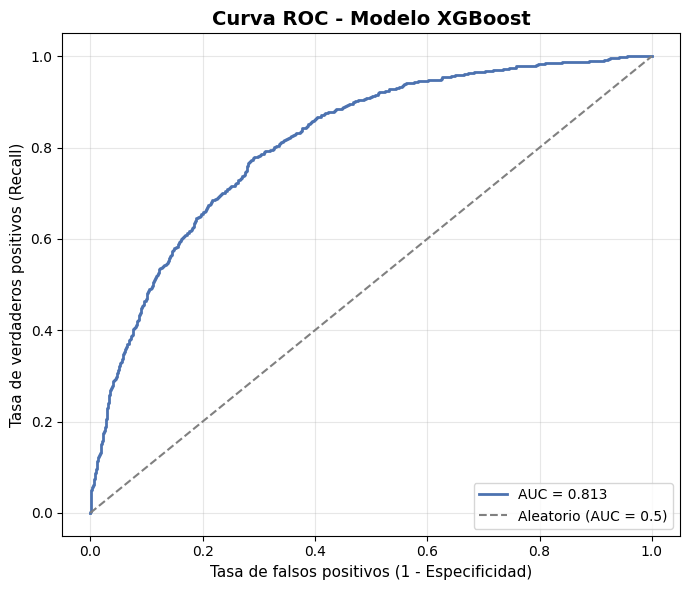

In [12]:
#Curva ROC 
y_pred_proba = best_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_value = roc_auc_score(y_test, y_pred_proba)

# Graficación
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color="#4C72B0", lw=2, label=f"AUC = {auc_value:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1.5, label="Aleatorio (AUC = 0.5)")
plt.xlabel("Tasa de falsos positivos (1 - Especificidad)", fontsize=11)
plt.ylabel("Tasa de verdaderos positivos (Recall)", fontsize=11)
plt.title("Curva ROC - Modelo XGBoost", fontsize=14, weight="bold")
plt.legend(loc="lower right", frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Matriz de confusion

In [13]:
# Índice de Youden para optimizar umbral (maximiza sensibilidad + especificidad)
youden = tpr - fpr
best_threshold = thresholds[np.argmax(youden)]
print(f"Umbral óptimo (Youden): {best_threshold:.3f}")

Umbral óptimo (Youden): 0.454


In [14]:
threshold = 0.454
y_pred = (y_pred_proba >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[1867  768]
 [ 194  684]]


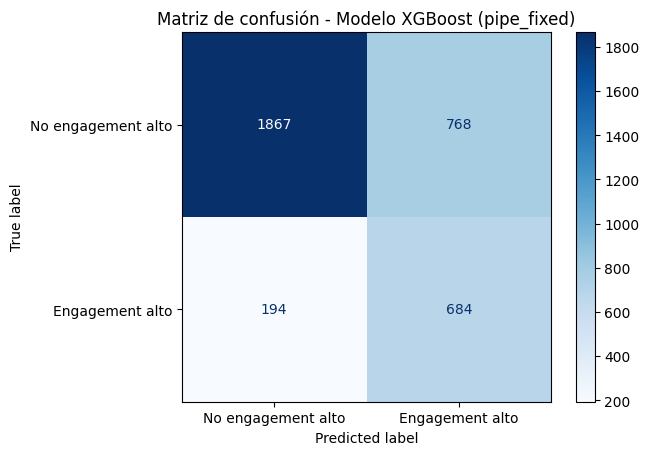

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No engagement alto", "Engagement alto"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - Modelo XGBoost (pipe_fixed)")
plt.show()

In [16]:

# 1️⃣ Predicciones de probabilidad
y_proba = best_pipe.predict_proba(X_test)[:, 1]

# 2️⃣ Cálculo de curvas PR para encontrar el mejor umbral
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Fβ-score (puedes cambiar β = 0.7, 1.0, etc.)
beta = 0.7
fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
fbeta = np.nan_to_num(fbeta)  # limpiar NaN
best_idx = np.argmax(fbeta)
best_threshold = thresholds[best_idx]
best_fbeta = fbeta[best_idx]

# 3️⃣ Clasificación binaria usando el umbral óptimo
y_pred = (y_proba >= best_threshold).astype(int)

# 4️⃣ Métricas finales
metrics = {
    "threshold": best_threshold,
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "fbeta_score": best_fbeta,
    "beta": beta,
    "accuracy": accuracy_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
    "pr_auc": average_precision_score(y_test, y_proba),
}

# 5️⃣ Mostrar resultados ordenados
df_metrics = pd.DataFrame([metrics]).T
df_metrics.columns = ["Valor"]
print(df_metrics)

# 6️⃣ (Opcional) Mostrar resumen bonito
print(f"\n--- Resultados XGBoost (target engagement) ---")
print(f"PR-AUC     : {metrics['pr_auc']:.3f}")
print(f"ROC-AUC    : {metrics['roc_auc']:.3f}")
print(f"Accuracy   : {metrics['accuracy']:.3f}")
print(f"F1-score   : {metrics['f1_score']:.3f}")
print(f"Fβ({metrics['beta']}) : {metrics['fbeta_score']:.3f}")
print(f"Precision  : {metrics['precision']:.3f}")
print(f"Recall     : {metrics['recall']:.3f}")

                Valor
threshold    0.657155
precision    0.591425
recall       0.534169
f1_score     0.561341
fbeta_score  0.571287
beta         0.700000
accuracy     0.791346
roc_auc      0.813166
pr_auc       0.585808

--- Resultados XGBoost (target engagement) ---
PR-AUC     : 0.586
ROC-AUC    : 0.813
Accuracy   : 0.791
F1-score   : 0.561
Fβ(0.7) : 0.571
Precision  : 0.591
Recall     : 0.534


### 3.1.5.1 SHAP


X_test_df: (3513, 70)  | Ejemplo cols: ['duration_minutes', 'has_caption', 'licensed_content', 'definition', 'frecuencia_videos', 'category_id_1.0', 'category_id_2.0', 'category_id_10.0']

Top-20 |SHAP| medio
              feature  mean_abs_shap
0    duration_minutes       0.840392
1   frecuencia_videos       0.378858
2               emb_5       0.216486
3               emb_6       0.212593
4               emb_2       0.149965
5               emb_0       0.098032
6               emb_4       0.095169
7              emb_42       0.091963
8              emb_12       0.090425
9              emb_13       0.084705
10              emb_3       0.082141
11             emb_18       0.076294
12             emb_46       0.070055
13              emb_8       0.067723
14             emb_24       0.063692
15              emb_1       0.060214
16             emb_35       0.059358
17             emb_49       0.052630
18   category_id_27.0       0.050896
19             emb_16       0.048723


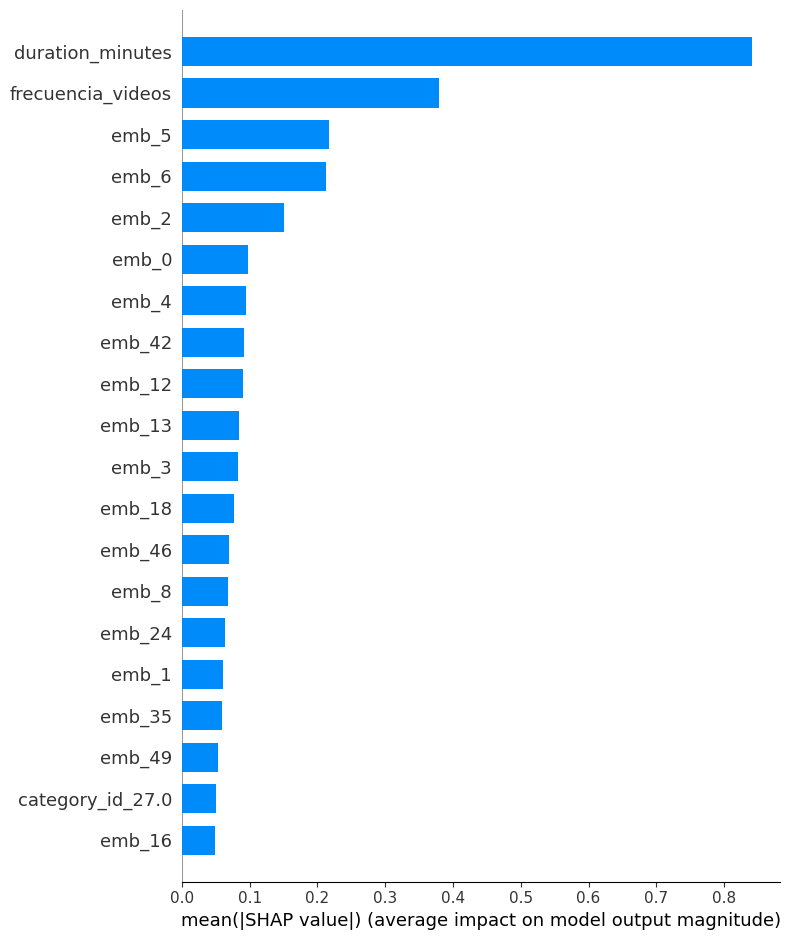

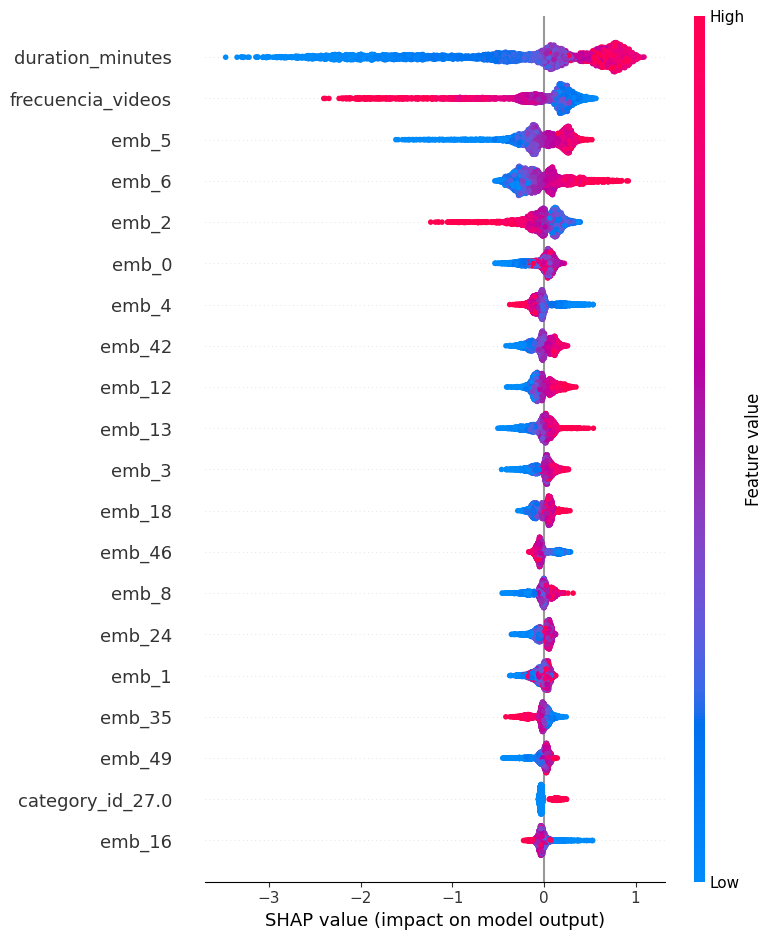

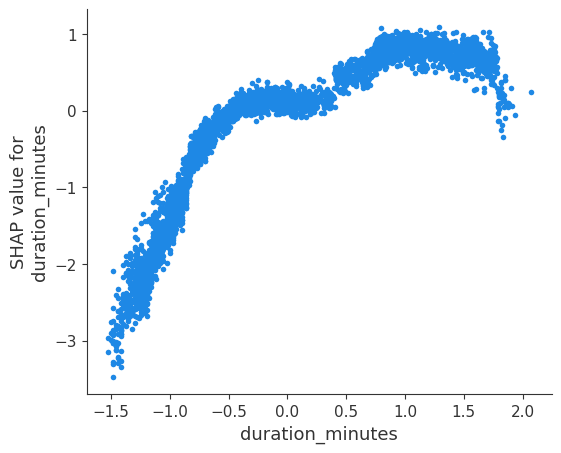

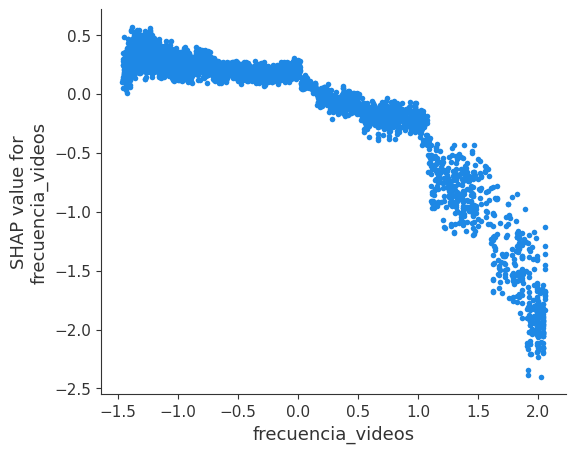

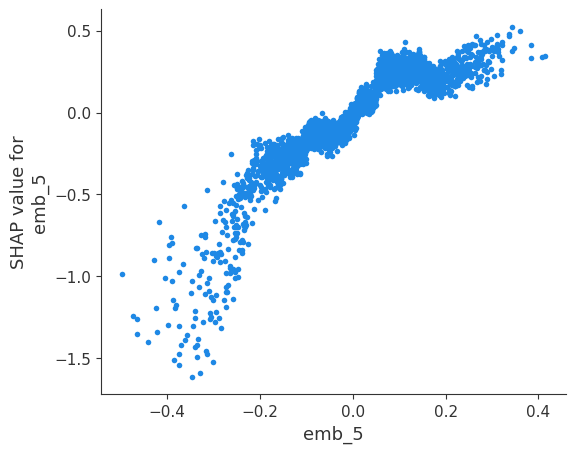

In [17]:
# Funciones que ayudan a operativizar pipeline
def _resolve_cols(cols, X_sample: pd.DataFrame):
    if callable(cols):
        cols = cols(X_sample)
    if isinstance(cols, slice):
        return list(X_sample.columns[cols])
    if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
        if len(cols) > 0 and isinstance(cols[0], (int, np.integer)):
            return list(X_sample.columns[list(cols)])
        if isinstance(cols, (np.ndarray, pd.Index)) and getattr(cols, "dtype", None) == bool:
            return list(X_sample.columns[cols])
        return list(cols)
    return [cols]

def get_ct_feature_names_compat(ct, X_sample: pd.DataFrame):
    out = []
    for name, trans, cols in ct.transformers_:
        if trans == "drop":
            continue
        cols_res = _resolve_cols(cols, X_sample)

        # 1) si tiene get_feature_names_out, úsalo
        if hasattr(trans, "get_feature_names_out"):
            try:
                feats = trans.get_feature_names_out(cols_res)
                out.extend(list(feats))
                continue
            except Exception:
                pass

        # 2) passthrough
        if trans == "passthrough":
            out.extend(cols_res)
            continue

        # 3) infiere n_cols transformando una muestra
        X_slice = X_sample[cols_res]
        try:
            Xt = trans.transform(X_slice)
        except Exception:
            n = min(50, len(X_slice))
            Xt = trans.transform(X_slice.iloc[:n])

        if sparse.issparse(Xt):
            Xt = Xt.toarray()
        else:
            Xt = np.asarray(Xt)

        n_out = Xt.shape[1] if Xt.ndim > 1 else 1
        out.extend([f"{name}_{i}" for i in range(n_out)])
    return np.array(out, dtype=object)

# Toma el preprocesador y DESACTIVA pandas-output
ct = best_pipe.named_steps["preprocessing"]
try:
    ct.set_output(transform="default")  # clave: nada de pandas aquí
except Exception:
    pass

# Desactiva pandas-output dentro del OHE ya ajustado (si existe esa rama)
try:
    cat_tr = ct.named_transformers_.get("cat", None)
    if cat_tr is not None and hasattr(cat_tr, "named_steps"):
        ohe = cat_tr.named_steps.get("ohe", None)
        if ohe is not None and hasattr(ohe, "set_output"):
            ohe.set_output(transform="default")
except Exception:
    pass

# Transforma X_test y crea DataFrame denso + nombres
# (mediante el uso de muestras del train se resuelve nombres de forma estable)
best_pipe.fit(X_train, y_train)

ct = best_pipe.named_steps["preprocessing"]   # <- ahora SÍ está fitted
X_sample = X_train.iloc[:min(100, len(X_train))].copy()

try: ct.set_output(transform="default")
except: pass

feature_names = get_ct_feature_names_compat(ct, X_sample)
Xt = ct.transform(X_test)   # ya no falla
X_sample = X_train.iloc[: min(100, len(X_train))].copy()
feature_names = get_ct_feature_names_compat(ct, X_sample)

Xt = ct.transform(X_test)  # puede ser sparse
if sparse.issparse(Xt):
    Xt = Xt.toarray()

X_test_df = pd.DataFrame(Xt, columns=feature_names)
print("X_test_df:", X_test_df.shape, " | Ejemplo cols:", X_test_df.columns[:8].tolist())

# SHAP con TreeExplainer para XGBoost ----------
xgb_final = best_pipe.named_steps["model"]
explainer = shap.TreeExplainer(xgb_final)

# para versiones nuevas de shap, mejor pasar ndarray; aquí pasamos DataFrame para nombres en plots
shap_values = explainer.shap_values(X_test_df)

# TOP-20 SHAP
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(-mean_abs_shap)[:20]
top_features = (pd.DataFrame({
    "feature": X_test_df.columns[top_idx],
    "mean_abs_shap": mean_abs_shap[top_idx]
})
.sort_values("mean_abs_shap", ascending=False)
.reset_index(drop=True))

print("\nTop-20 |SHAP| medio")
print(top_features)

# Plots 
# a) barras (importancia global)
shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=20)
# b) beeswarm (dirección del efecto)
shap.summary_plot(shap_values, X_test_df, max_display=20)

# Categorías más influyentes
for feat in top_features["feature"].head(3):
    try:
        shap.dependence_plot(feat, shap_values, X_test_df, interaction_index=None)
    except Exception as e:
        print(f"Dependence plot falló para {feat}: {e}")

## 3.1.6. RED NEURONAL

In [18]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),   
    activation="relu",
    solver="adam",
    alpha=1e-4,                     
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.2,
    random_state=42,
    verbose=False
)


pipeline_power = Pipeline(
    steps=[
    ('preprocessing', preprocessor),
    ('model', mlp),
])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 
    groups=groups,          
    scoring="roc_auc",
    n_jobs=-1
)

result = evaluate_auc_oof_test(
    model=pipeline_power,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    groups_train=groups,            # <--- NUEVO
    n_splits=5, random_state=42
)
print(result)

AUC OOF (GroupKFold): 0.7803
AUC Test:            0.7756
{'AUC_OOF': 0.7802563568495762, 'AUC_Test': 0.7756061084144144}


## 3.1.7 Análisis de variables cluster

In [19]:
df_2=pd.read_parquet("../DATA/PROCESSED/df_TFMYouTube_embeddings_UMAP5_CLUSTERS_UMAP2.parquet")
df_1[["umap2_x", "umap2_y","cluster_umap5", "views", "likes", "comments", "engagement_rate",]] = df_2[["umap2_x", "umap2_y","cluster_umap5", "views", "likes", "comments", "engagement_rate"]]

best_pipe = xgb_search.best_estimator_  # o joblib.load("models/mostpopular/artifacts/model.joblib")

# Localiza el PCA que procesó 'embedding_joint' dentro del preprocessor
pre = best_pipe.named_steps["preprocessing"]

# Ajuste a la configuración real:
pca = pre.named_transformers_["emb"].named_steps["pca"]   # e.g. Pipeline([("scaler", ...), ("pca", PCA(...))])

# Preparación de la matriz a partir de la columna 'embedding_joint'
# Si 'embedding_joint' ya es un array/lista por fila:
def to_vec(x):
    # x puede venir como lista, np.array o string de lista -> normalízalo
    if isinstance(x, str):
        import ast
        return np.array(ast.literal_eval(x), dtype=float)
    return np.array(x, dtype=float)

E = np.vstack(df_1["embedding_joint"].apply(to_vec).values)  # shape: (n_samples, d)

# Transforma con el PCA ya entrenado
Z = pca.transform(E)  # shape: (n_samples, n_components)

# Vuelca a columnas emb_1..emb_k
k = Z.shape[1]
emb_cols = [f"emb_{i+1}" for i in range(k)]
df_1[emb_cols] = Z

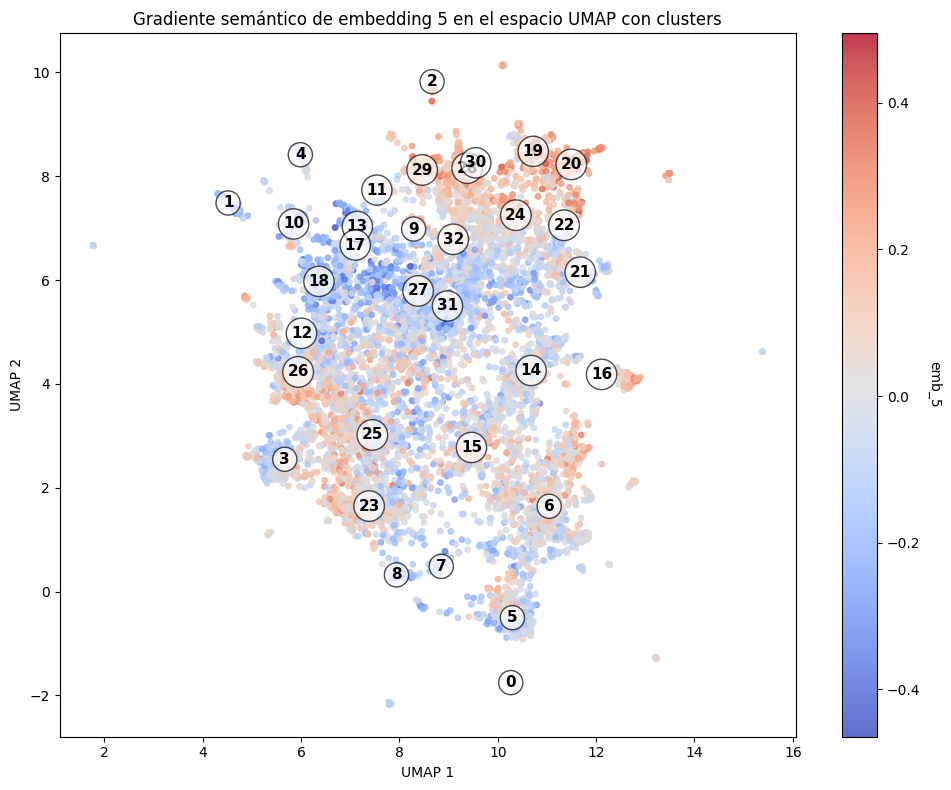

In [20]:
df_plot = df_1.sample(min(8000, len(df_1)), random_state=42)

# Figura base
plt.figure(figsize=(10, 8))

# Puntos coloreados por emb_10
sc = plt.scatter(
    df_plot["umap2_x"], df_plot["umap2_y"],
    c=df_plot["emb_5"], cmap="coolwarm", s=15, alpha=0.8
)

# Colorbar continua
cbar = plt.colorbar(sc)
cbar.set_label("emb_5", rotation=270, labelpad=15)

# Añade los números de los clusters UMAP
centroids = (
    df_1[df_1["cluster_umap5"] != -1]  # excluye ruido
    .groupby("cluster_umap5")[["umap2_x", "umap2_y"]]
    .mean()
    .reset_index()
)

for _, row in centroids.iterrows():
    plt.text(
        row["umap2_x"], row["umap2_y"],
        str(int(row["cluster_umap5"])),
        fontsize=11, fontweight="bold",
        ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="black", alpha=0.7, boxstyle="circle,pad=0.3")
    )

# Gráfica
plt.title("Gradiente semántico de embedding 5 en el espacio UMAP con clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

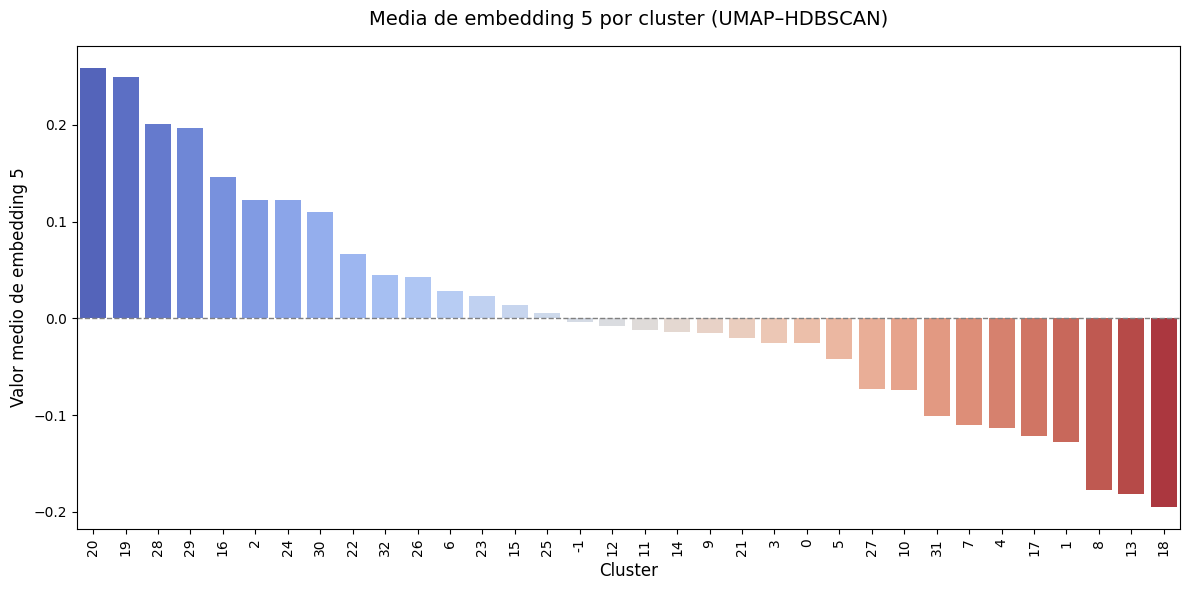

In [21]:
# Calcular la media del embedding 1 por cluster y ordenarla de mayor a menor
mean_emb5 = (
    df_1.groupby("cluster_umap5")["emb_5"]
        .mean()
        .sort_values(ascending=False)
)

# Graficar en el orden correcto
plt.figure(figsize=(12, 6))
sns.barplot(
    x=mean_emb5.index.astype(str),  # convertir a string para evitar errores con el orden
    y=mean_emb5.values,
    palette="coolwarm",
    order=mean_emb5.index.astype(str)  # mantener el orden de mayor a menor
)

# Línea base y etiquetas
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Media de embedding 5 por cluster (UMAP–HDBSCAN)", fontsize=14, pad=15)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Valor medio de embedding 5", fontsize=12)

# Rotación de etiquetas
plt.xticks(rotation=90, ha="center")

plt.tight_layout()
plt.show()

In [22]:
df_1.groupby("cluster_umap5")["emb_5"].mean().sort_values()

cluster_umap5
 18   -0.195087
 13   -0.182095
 8    -0.177891
 1    -0.127879
 17   -0.121574
 4    -0.113461
 7    -0.110523
 31   -0.100713
 10   -0.073599
 27   -0.073173
 5    -0.041641
 0    -0.025137
 3    -0.025022
 21   -0.020792
 9    -0.014827
 14   -0.013626
 11   -0.011653
 12   -0.007581
-1    -0.003902
 25    0.005757
 15    0.013763
 23    0.022638
 6     0.028387
 26    0.042475
 32    0.045211
 22    0.066224
 30    0.109963
 24    0.122526
 2     0.122635
 16    0.146366
 29    0.196950
 28    0.200519
 19    0.249633
 20    0.259020
Name: emb_5, dtype: float64

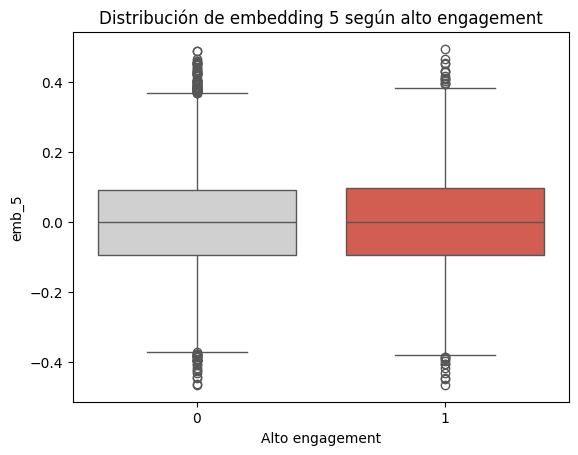

In [23]:
sns.boxplot(data=df_1, x="target_engagement", y="emb_5", palette=["#d0d0d0","#e74c3c"])
plt.title("Distribución de embedding 5 según alto engagement"); plt.xlabel("Alto engagement"); plt.ylabel("emb_5")
plt.show()

<Axes: >

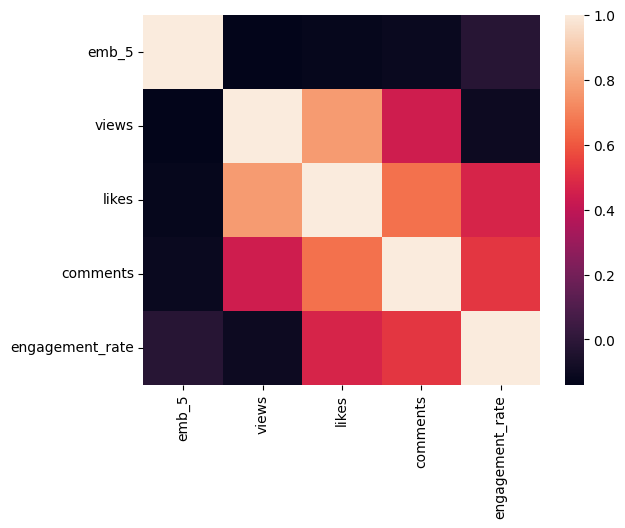

In [24]:
corr=df_1[["emb_5", "views", "likes", "comments", "engagement_rate"]].corr(method="spearman")
sns.heatmap(corr)